In [24]:
# Are we using a GPU?
!nvidia-smi

Tue Sep  5 16:17:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [25]:
# Downloading and becoming with data (only 10%)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip


--2023-09-05 16:17:51--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.135.207, 173.194.203.207, 74.125.199.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.135.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   158MB/s    in 1.0s    

2023-09-05 16:17:52 (158 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [26]:
# Unzip data file
import zipfile

zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()


In [27]:
# walk through he data
import os

for dir_paths, dir_names, file_names in os.walk('10_food_classes_10_percent'): # not able to walk through zip files
  #print('1')
  print(f'there are {len(dir_names)} directories, {len(file_names)} images in {dir_paths}')

there are 2 directories, 0 images in 10_food_classes_10_percent
there are 10 directories, 0 images in 10_food_classes_10_percent/test
there are 0 directories, 250 images in 10_food_classes_10_percent/test/grilled_salmon
there are 0 directories, 250 images in 10_food_classes_10_percent/test/chicken_curry
there are 0 directories, 250 images in 10_food_classes_10_percent/test/sushi
there are 0 directories, 250 images in 10_food_classes_10_percent/test/hamburger
there are 0 directories, 250 images in 10_food_classes_10_percent/test/chicken_wings
there are 0 directories, 250 images in 10_food_classes_10_percent/test/steak
there are 0 directories, 250 images in 10_food_classes_10_percent/test/fried_rice
there are 0 directories, 250 images in 10_food_classes_10_percent/test/ramen
there are 0 directories, 250 images in 10_food_classes_10_percent/test/pizza
there are 0 directories, 250 images in 10_food_classes_10_percent/test/ice_cream
there are 10 directories, 0 images in 10_food_classes_10_p

In [28]:
# setup input data

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/content/10_food_classes_10_percent/train'
test_dir = '/content/10_food_classes_10_percent/test'

image_datagen = ImageDataGenerator(rescale=1/255.)

train_data = image_datagen.flow_from_directory(train_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode='categorical')

test_data = image_datagen.flow_from_directory(test_dir,
                                              batch_size=32,
                                              target_size=(224, 224),
                                              class_mode='categorical')


Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [29]:
# Create TensorBoard callback (functionized beause we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [31]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers


In [30]:
def create_model(model_url, num_classes):
  '''
  Takes a TensorFlow hub URL and create a Keras model with it (Sequential).

  Args:
  model_url: A tensorflow hub freature extraction URL.
  num_classes: Number of class of the dataset. (output neurons).

  Returns:
  An uncompiled keras Sequential model with model_url as feature
  extractor layer and Dense output layer.
  '''

  # Download pretrain model and save it as a keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name='freature_extractor_layers',
                                           input_shape=(224 ,224, 3))

  # Model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      tf.keras.layers.Dense(num_classes, activation='softmax')

  ], name='model')

  return model

In [32]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"


In [33]:
# Create model
resnet_model = create_model(resnet_url, train_data.num_classes)

# Compile the model
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [34]:
resnet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 freature_extractor_layers (  (None, 2048)             23564800  
 KerasLayer)                                                     
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [35]:
resnet_history = resnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20230905-170610
Epoch 1/5
24/24 [==============================] - 27s 547ms/step - loss: 1.9384 - accuracy: 0.3547 - val_loss: 1.1862 - val_accuracy: 0.6232
Epoch 2/5
24/24 [==============================] - 10s 442ms/step - loss: 0.8996 - accuracy: 0.7493 - val_loss: 0.8352 - val_accuracy: 0.7312
Epoch 3/5
24/24 [==============================] - 10s 436ms/step - loss: 0.6126 - accuracy: 0.8267 - val_loss: 0.7486 - val_accuracy: 0.7528
Epoch 4/5
24/24 [==============================] - 11s 451ms/step - loss: 0.4804 - accuracy: 0.8827 - val_loss: 0.6910 - val_accuracy: 0.7740
Epoch 5/5
24/24 [==============================] - 10s 416ms/step - loss: 0.3869 - accuracy: 0.9107 - val_loss: 0.6600 - val_accuracy: 0.7836


In [36]:
# create efficientnet model
efficientnet_model = create_model(efficientnet_url, train_data.num_classes)

# Compile th emodel
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])


In [37]:
efficientnet_history = efficientnet_model.fit(train_data,
                                              epochs=5,
                                              steps_per_epoch=len(train_data),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                                     experiment_name='efficientnet')])

Saving TensorBoard log files to: tensorflow_hub/efficientnet/20230905-171319
Epoch 1/5
24/24 [==============================] - 22s 490ms/step - loss: 1.8591 - accuracy: 0.4453 - val_loss: 1.3029 - val_accuracy: 0.7364
Epoch 2/5
24/24 [==============================] - 9s 401ms/step - loss: 1.0682 - accuracy: 0.7760 - val_loss: 0.8713 - val_accuracy: 0.8208
Epoch 3/5
24/24 [==============================] - 11s 456ms/step - loss: 0.7559 - accuracy: 0.8253 - val_loss: 0.7003 - val_accuracy: 0.8420
Epoch 4/5
24/24 [==============================] - 9s 396ms/step - loss: 0.6113 - accuracy: 0.8627 - val_loss: 0.6147 - val_accuracy: 0.8500
Epoch 5/5
24/24 [==============================] - 10s 411ms/step - loss: 0.5156 - accuracy: 0.8840 - val_loss: 0.5613 - val_accuracy: 0.8552


<Axes: title={'center': 'efficientnet curves'}>

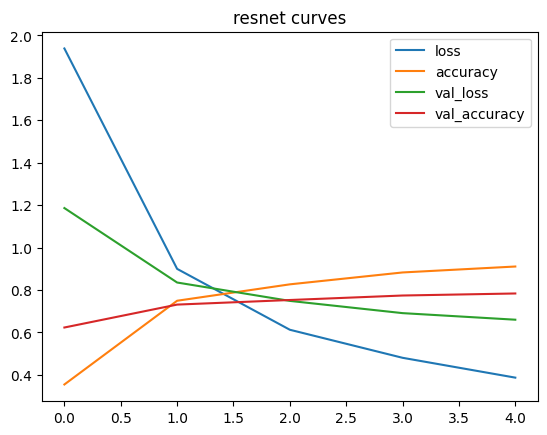

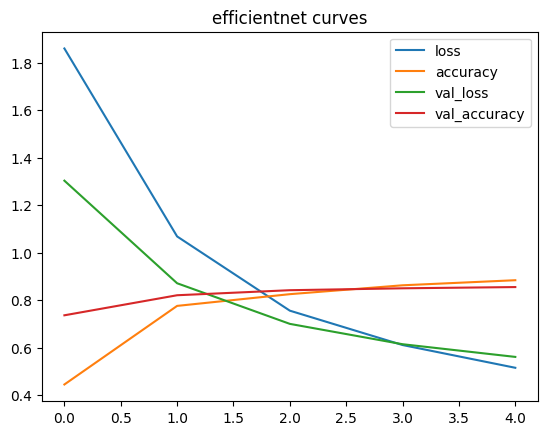

In [41]:
import pandas as pd

pd.DataFrame(resnet_history.history).plot(title='resnet curves')
pd.DataFrame(efficientnet_history.history).plot(title='efficientnet curves')


In [42]:
# https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5
# mobilenet model
mobilenet_url='https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5'

# Create model
mobilenet_model = create_model(mobilenet_url, train_data.num_classes)

# compile the model
mobilenet_model.compile(loss='categorical_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=['accuracy'])



In [43]:
mobilenet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 freature_extractor_layers (  (None, 1280)             2257984   
 KerasLayer)                                                     
                                                                 
 dense_2 (Dense)             (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [45]:
mobilenet_model_history = mobilenet_model.fit(train_data,
                                              epochs=5,
                                              steps_per_epoch=len(train_data),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                                     experiment_name='mobile_net')])

Saving TensorBoard log files to: tensorflow_hub/mobile_net/20230905-181207
Epoch 1/5
24/24 [==============================] - 18s 565ms/step - loss: 1.9846 - accuracy: 0.3040 - val_loss: 1.3447 - val_accuracy: 0.5980
Epoch 2/5
24/24 [==============================] - 12s 530ms/step - loss: 1.0200 - accuracy: 0.7133 - val_loss: 0.8871 - val_accuracy: 0.7472
Epoch 3/5
24/24 [==============================] - 12s 533ms/step - loss: 0.7132 - accuracy: 0.8160 - val_loss: 0.7380 - val_accuracy: 0.7848
Epoch 4/5
24/24 [==============================] - 13s 537ms/step - loss: 0.5579 - accuracy: 0.8680 - val_loss: 0.6809 - val_accuracy: 0.7952
Epoch 5/5
24/24 [==============================] - 9s 405ms/step - loss: 0.4685 - accuracy: 0.8973 - val_loss: 0.6277 - val_accuracy: 0.8136


In [46]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2 vs. MobilenetV2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot

2023-09-05 18:14:49.164812: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   CRJ-HVH-GTM



New experiment created. View your TensorBoard at: https://tensorboard.dev/ex

<Axes: title={'center': 'mobileNet curves'}>

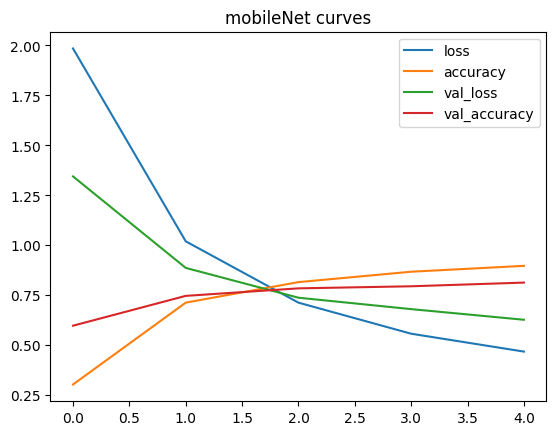

In [48]:
pd.DataFrame(mobilenet_model_history.history).plot(title='mobileNet curves')


Here, EfficientNet gives you best performencs for this 10% dataset